In [24]:
!pip install nltk
!pip install textblob
!pip install wordcloud

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
def preprocess_text(text):
  tokenized_document = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9]+').tokenize(text) #Tokenize
  cleaned_tokens = [word.lower() for word in tokenized_document if word.lower() not in stop_words] #Remove
  stemmed_text = [nltk.stem.PorterStemmer().stem(word) for word in cleaned_tokens] #Stemming
  return stemmed_text

In [5]:
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/amazon_reviews.csv")

In [6]:
df = df.copy()

In [7]:
df = df.sort_values("wilson_lower_bound", ascending=False)
df.drop('Unnamed: 0', inplace = True, axis = 1)
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5.0,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,2013-01-05,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5.0,I have tested dozens of SDHC and micro-SDHC ca...,2012-09-26,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1.0,NOTE: please read the last update (scroll to ...,2013-05-08,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1.0,"If your card gets hot enough to be painful, it...",2012-02-09,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5.0,Sandisk announcement of the first 128GB micro ...,2014-07-03,158,45,4,49,41,0.918367,0.808109


In [22]:
df.tail()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
1712,G. Abbott,5.0,I use this in my Samsung Galaxy S5 to store my...,2014-06-24,167,0,0,0,0,0.0,0.0
1711,G68,5.0,awesome! Worked well with the Surface 2 tablet...,2014-08-04,126,0,0,0,0,0.0,0.0
1710,G0Horns!,4.0,Its amazing the amount of storage we are putti...,2013-05-27,560,0,0,0,0,0.0,0.0
1709,g0estoeleven,3.0,This card does exactly what it should. Class-...,2013-03-08,640,0,0,0,0,0.0,0.0
4914,Zza,5.0,I've heard bad things about this 64gb Micro SD...,2014-02-01,310,0,0,0,0,0.0,0.0


In [23]:
df.duplicated().sum()

0

In [24]:
df.isnull().sum()

reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [20]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail = 5):

    print(" SHAPE ".center(82,'~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print(" TYPES ".center(82,'~'))
    print(df.dtypes)
    print("".center(82,'~'))
    print(missing_values_analysis(df))
    print(' DUPLICATED VALUES '.center(83,'~'))
    print(df.duplicated().sum())
    print(" QUANTILES ".center(82,'~'))
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                 float64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Total Missing Values  Ratio
reviewerName                     1   0.02
reviewText                       1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ DUPLICATED VALUES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ QUANTILES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00  0.05   0.50        0.95       0.99    

<ipython-input-20-aff789fc0305>:21: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [21]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                               'Classes': [dataframe[i].nunique() \
                                           for i in dataframe.columns]})

    nunique_df = nunique_df.sort_values('Classes', ascending=False)
    nunique_df = nunique_df.reset_index(drop = True)
    return nunique_df

check_class(df)

,Variable,Classes
0,reviewText,4912
1,reviewerName,4594
2,reviewTime,690
3,day_diff,690
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,4915.0,4.587589,0.996845,1.0,5.0,5.0,5.0,5.000000
day_diff,4915.0,437.367040,209.439871,1.0,281.0,431.0,601.0,1064.000000
helpful_yes,4915.0,1.311089,41.619161,0.0,0.0,0.0,0.0,1952.000000
helpful_no,4915.0,0.210376,4.023296,0.0,0.0,0.0,0.0,183.000000
total_vote,4915.0,1.521465,44.123095,0.0,0.0,0.0,0.0,2020.000000
score_pos_neg_diff,4915.0,1.100712,39.367949,-130.0,0.0,0.0,0.0,1884.000000
score_average_rating,4915.0,0.075468,0.256062,0.0,0.0,0.0,0.0,1.000000
wilson_lower_bound,4915.0,0.020053,0.077187,0.0,0.0,0.0,0.0,0.957544


In [17]:
import pandas as pd

# Assuming you've read the data into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_reviews.csv', encoding='latin-1')

# Print the columns to verify their names
print(df.columns)

# List of columns to drop
columns_to_drop = [ 'wilson_lower_bound', 'reviewerName']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)
df.head()


Index(['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound'],
      dtype='object')


,Unnamed: 0,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating
0,0,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0
1,1,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0
2,2,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0
3,3,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0
4,4,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0


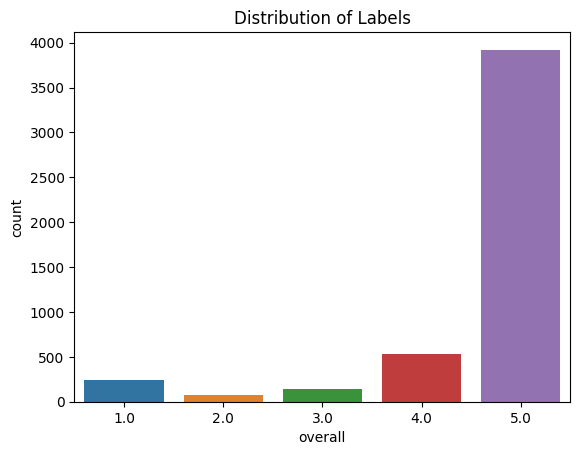

In [14]:
# Distribution of labels
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='overall', data=df)
plt.title('Distribution of Labels')
plt.show()

In [18]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove special characters and make it lower case
    text = re.sub(r'[^a-zA-ZÀ-ú\s]', '', text.lower())

    # Tokenization
    tokens = text.split()

    # Remove numbers
    tokens = [token for token in tokens if not token.isdigit()]

    # Remove punctuation
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Remove extra whitespace
    tokens = [token.strip() for token in tokens]

    # Remove two letter words
    tokens = [token for token in tokens if len(token) > 2]

    # Join the tokens back into a single text
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [16]:
df.head

<bound method NDFrame.head of       Unnamed: 0  overall  reviewTime  day_diff  helpful_yes  helpful_no  \
0              0      4.0  2014-07-23       138            0           0   
1              1      5.0  2013-10-25       409            0           0   
2              2      4.0  2012-12-23       715            0           0   
3              3      5.0  2013-11-21       382            0           0   
4              4      5.0  2013-07-13       513            0           0   
...          ...      ...         ...       ...          ...         ...   
4910        4910      1.0  2013-07-23       503            0           0   
4911        4911      5.0  2013-08-22       473            0           0   
4912        4912      5.0  2014-03-31       252            0           0   
4913        4913      5.0  2013-09-16       448            0           0   
4914        4914      5.0  2014-02-01       310            0           0   

      total_vote  score_pos_neg_diff  score_average_ratin

In [29]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Assuming you've read the data into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_reviews.csv', encoding='latin-1')

# Function for text preprocessing
def text_preprocessing(text):
    # Convert to lowercase
    text = str(text).lower()  # Convert to string in case some entries are not strings

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join the words back into a string
    processed_text = ' '.join(words)

    return processed_text

# Apply text preprocessing to the "reviewText" column
df['reviewText'] = df['reviewText'].apply(text_preprocessing)

# Display the updated DataFrame
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.00,issu,2014-07-23,138,0,0,0,0,0.00,0.00
1,1,0mie,5.00,purchas devic work advertis never much phone m...,2013-10-25,409,0,0,0,0,0.00,0.00
2,2,1K3,4.00,work expect sprung higher capac think made bit...,2012-12-23,715,0,0,0,0,0.00,0.00
3,3,1m2,5.00,think work diff bran 64gb card went south 3 on...,2013-11-21,382,0,0,0,0,0.00,0.00
4,4,2&amp;1/2Men,5.00,bought retail packag arriv legit orang envelop...,2013-07-13,513,0,0,0,0,0.00,0.00


In [31]:
df["reviewText"].head()

0                                                 issu
1    purchas devic work advertis never much phone m...
2    work expect sprung higher capac think made bit...
3    think work diff bran 64gb card went south 3 on...
4    bought retail packag arriv legit orang envelop...
Name: reviewText, dtype: object

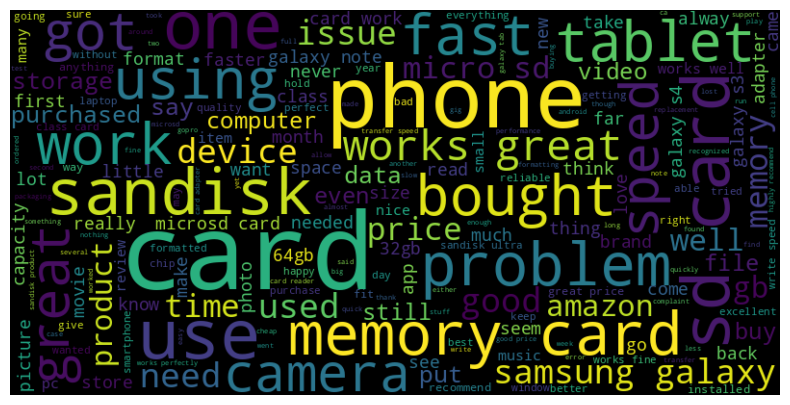

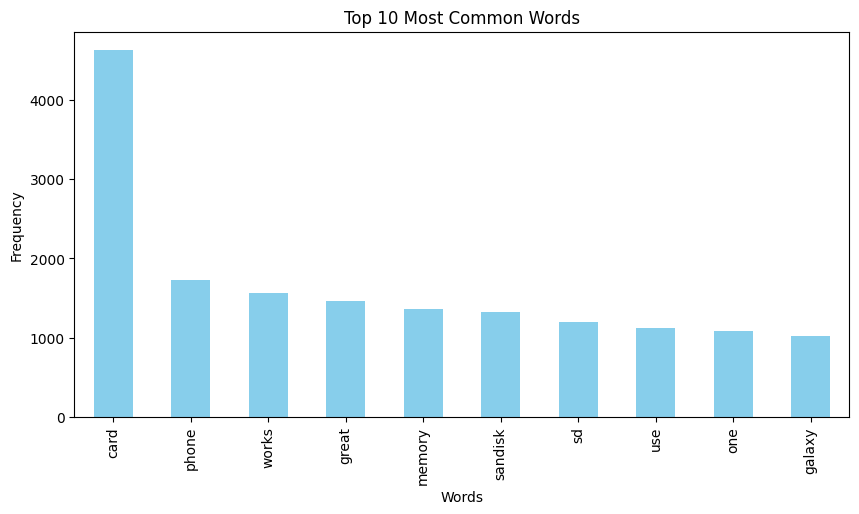

In [32]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_reviews.csv', encoding='latin-1')

def text_preprocessing(text):
    text = str(text).lower()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words and word not in string.punctuation]
    return ' '.join(words)

df['processed_review'] = df['reviewText'].apply(text_preprocessing)

all_reviews = ' '.join(df['processed_review'].astype(str))

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_reviews)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Plot the most common words using a bar plot
common_words = pd.Series(' '.join(df['processed_review']).split()).value_counts()[:10]
common_words.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


In [33]:
pip install textblob


In [34]:
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_reviews.csv', encoding='latin-1')

# Function for text preprocessing
def text_preprocessing(text):
    text = str(text).lower()
    return text

df['processed_review'] = df['reviewText'].apply(text_preprocessing)

# Map the sentiment labels (positive, neutral, negative)
df['sentiment'] = df['overall'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment'], test_size=0.2, random_state=42)

# Function to get sentiment polarity
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the sentiment analysis function to the training and testing sets
X_train_sentiments = X_train.apply(get_sentiment_polarity)
X_test_sentiments = X_test.apply(get_sentiment_polarity)

# Map the continuous sentiment values to discrete labels
y_train_pred = X_train_sentiments.apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
y_test_pred = X_test_sentiments.apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Training Accuracy: 0.8133265513733469
Testing Accuracy: 0.8026449643947101

Classification Report:
              precision    recall  f1-score   support

    negative       0.24      0.34      0.29        70
     neutral       0.00      0.00      0.00        25
    positive       0.93      0.86      0.89       888

    accuracy                           0.80       983
   macro avg       0.39      0.40      0.39       983
weighted avg       0.85      0.80      0.83       983


Confusion Matrix:
[[ 24   3  43]
 [  7   0  18]
 [ 67  56 765]]


In [35]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming you've read the data into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_reviews.csv', encoding='latin-1')

# Function for text preprocessing
def text_preprocessing(text):
    text = str(text).lower()
    return text

# Apply text preprocessing to the "reviewText" column
df['processed_review'] = df['reviewText'].apply(text_preprocessing)

# Map the sentiment labels (positive, neutral, negative)
df['sentiment'] = df['overall'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment'], test_size=0.2, random_state=42)

# Function to get sentiment intensity
def get_sentiment_intensity(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    return compound_score

# Apply the sentiment intensity function to the training and testing sets
X_train_sentiments = X_train.apply(get_sentiment_intensity)
X_test_sentiments = X_test.apply(get_sentiment_intensity)

# Map the continuous sentiment values to discrete labels
y_train_pred = X_train_sentiments.apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
y_test_pred = X_test_sentiments.apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Training Accuracy: 0.7670396744659207
Testing Accuracy: 0.7477110885045778

Classification Report:
              precision    recall  f1-score   support

    negative       0.23      0.60      0.33        70
     neutral       0.01      0.04      0.02        25
    positive       0.95      0.78      0.86       888

    accuracy                           0.75       983
   macro avg       0.40      0.47      0.40       983
weighted avg       0.87      0.75      0.80       983


Confusion Matrix:
[[ 42   3  25]
 [ 11   1  13]
 [132  64 692]]


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you've read the data into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_reviews.csv', encoding='latin-1')

# Function for text preprocessing
def text_preprocessing(text):
    text = str(text).lower()
    return text

# Apply text preprocessing to the "reviewText" column
df['processed_review'] = df['reviewText'].apply(text_preprocessing)

# Map the sentiment labels (positive, neutral, negative)
df['sentiment'] = df['overall'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define the SVM classifier
svm = SVC()

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Testing Accuracy: 0.9420142421159715

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.64      0.71        70
     neutral       0.00      0.00      0.00        25
    positive       0.95      0.99      0.97       888

    accuracy                           0.94       983
   macro avg       0.59      0.54      0.56       983
weighted avg       0.92      0.94      0.93       983


Confusion Matrix:
[[ 45   2  23]
 [  4   0  21]
 [  7   0 881]]


In [43]:
import pandas as pd

# Assuming you have some new data
new_data = pd.DataFrame({
    'reviewText': ['Your new review text here.', 'Another review for testing.']
})

# Preprocess the new data (assuming you have a function text_preprocessing for preprocessing)
new_data['reviewText'] = new_data['reviewText'].apply(text_preprocessing)
